# Genotype data preprocessing

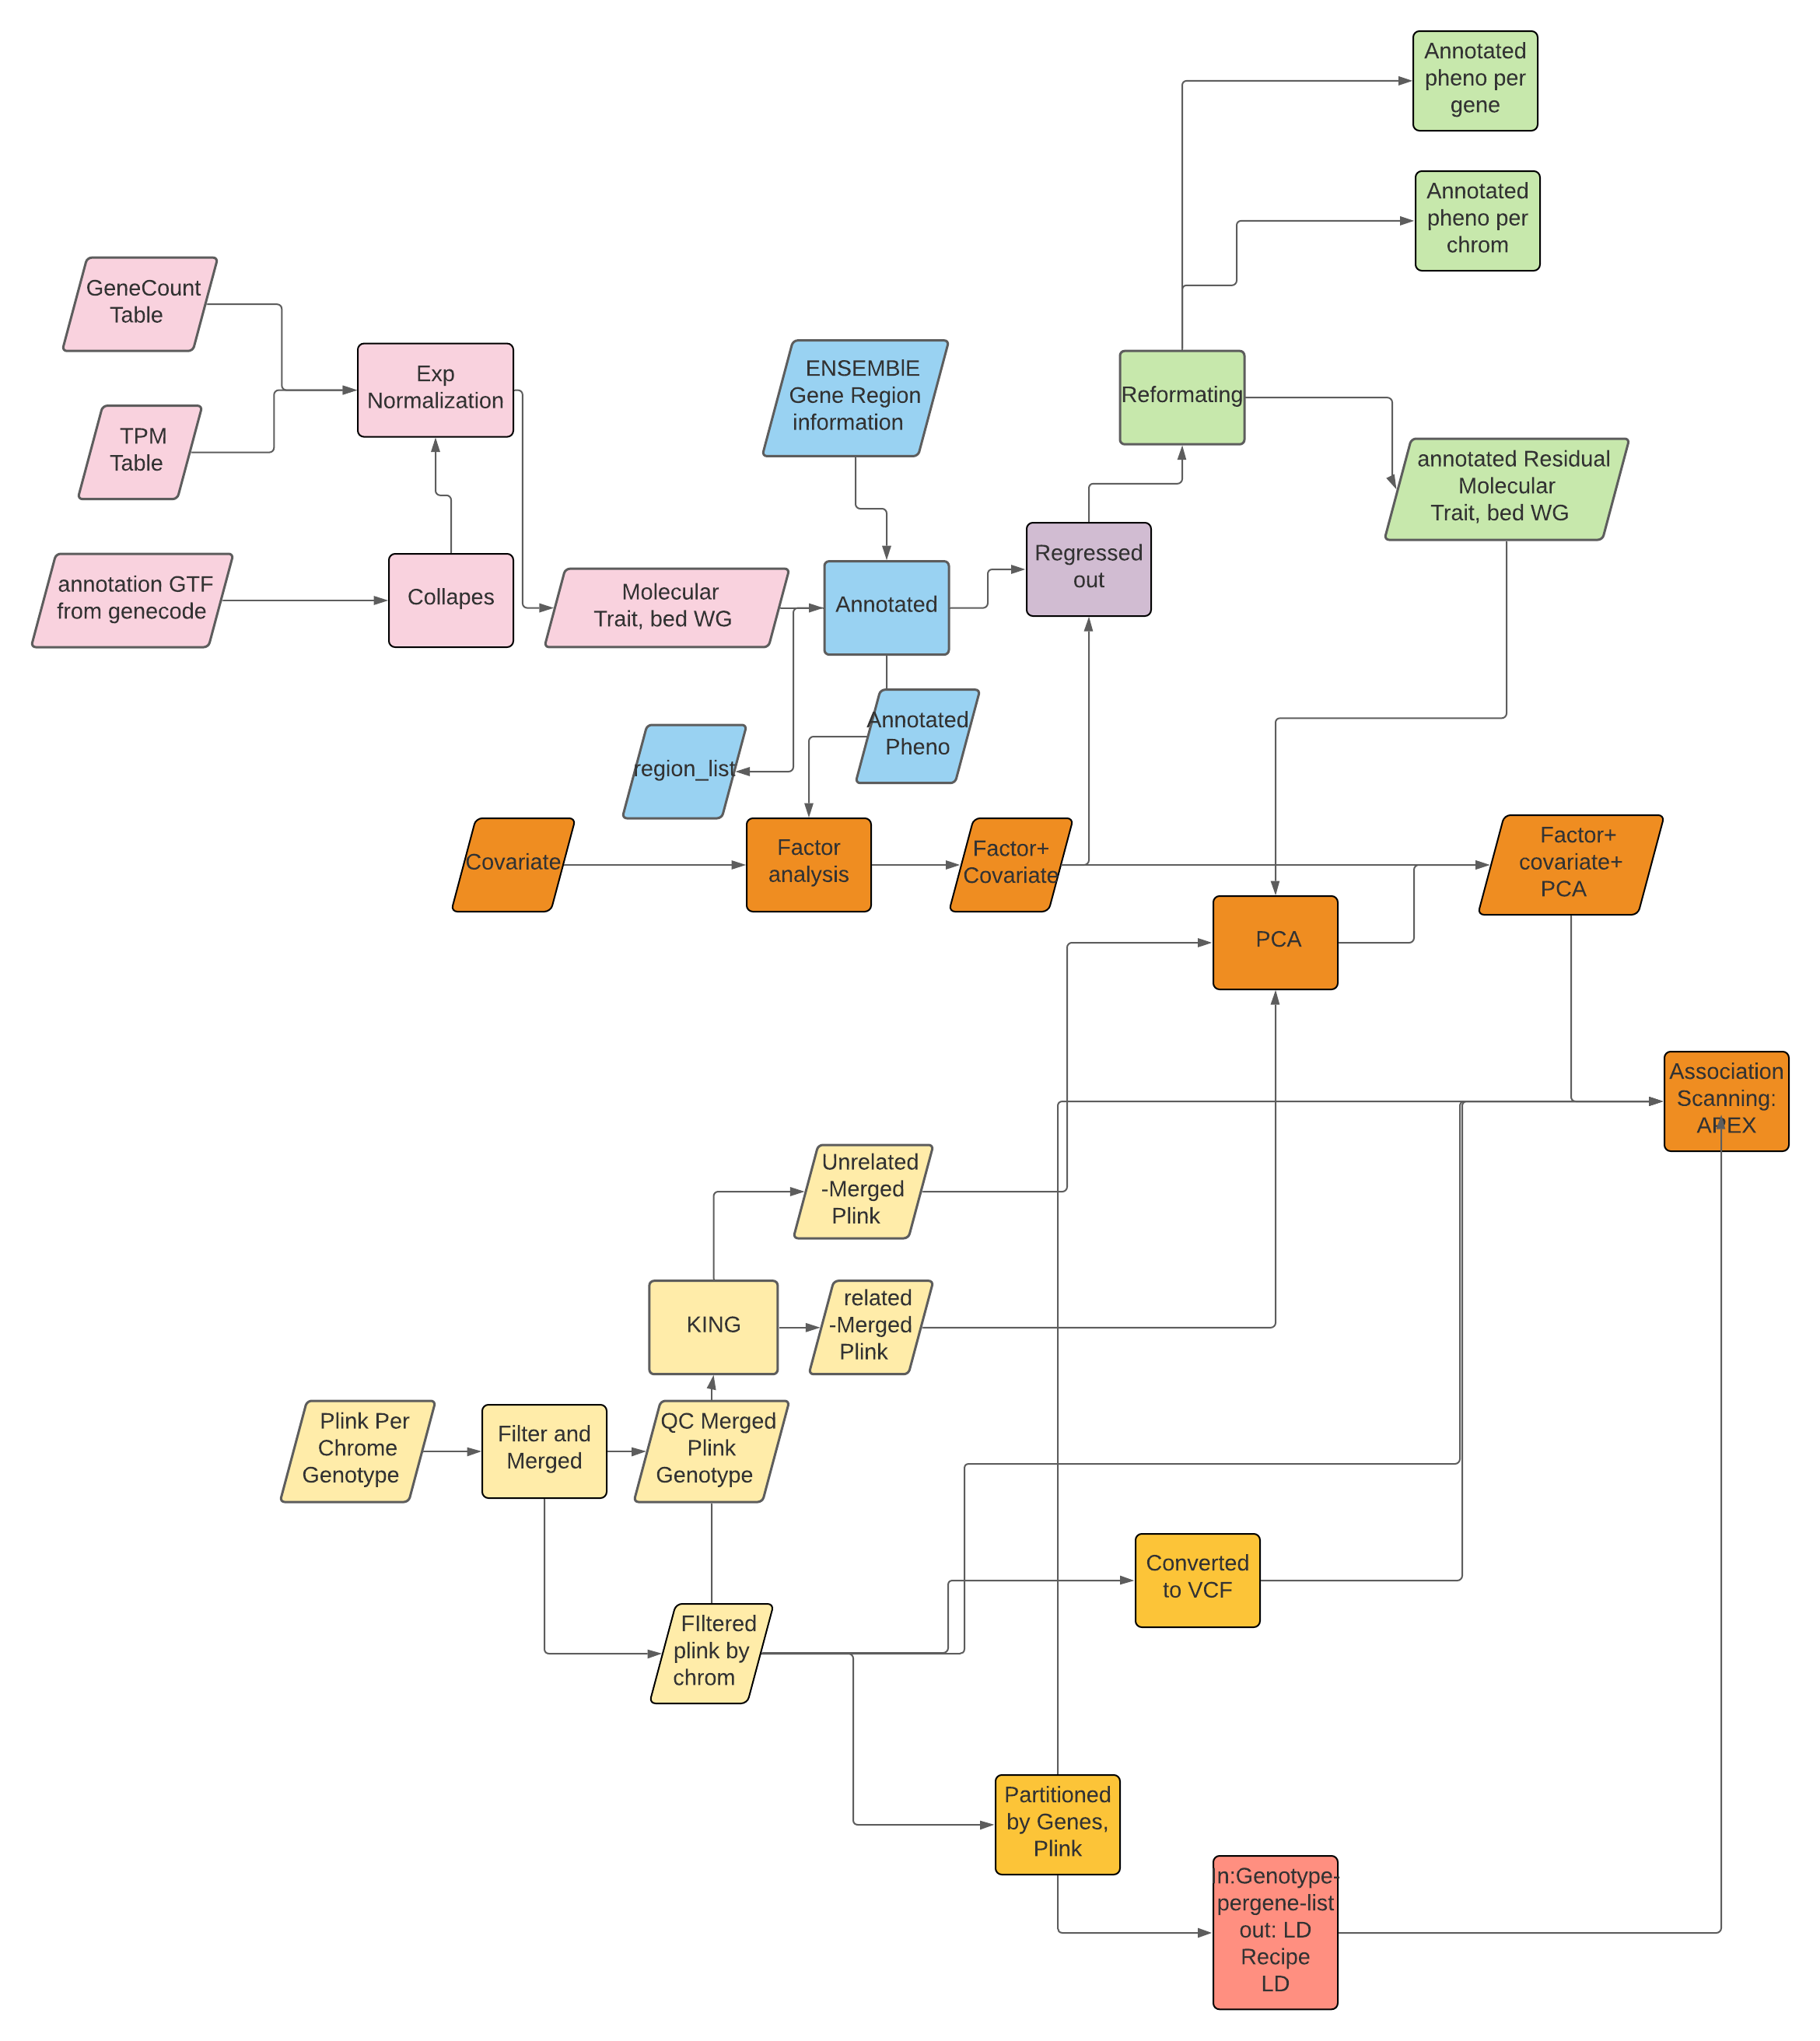

1. **This tutorial contains examples on running the light yellow, dark yellow, and red section of the following diagram.**
2. **Each commands in this tutorials should be run once per theme**

![captain](../../images/Data_proc_flowchart.png)

## Genotype QC(light yellow)

Input:
1. List of plink genotype per chrom

Output:
1. List of qced, LD-pruned, per chrom plink trio
2. qced, LD-pruned, whole genome plink trio
3. unrelated samples from 2
4. related samples from 2



In [ ]:
nohup sos run  /home/hs3163/GIT/xqtl-pipeline/pipeline/data_preprocessing/genotype/GWAS_QC.ipynb qc \
    --genotype_list /mnt/mfs/statgen/ROSMAP_xqtl/Rosmap_wgs_genotype_list.txt \
    --cwd /mnt/mfs/statgen/xqtl_workflow_testing/demo/AC/GWAS_QC/ \
    --name "ac" \
    --container_lmm "/mnt/mfs/statgen/containers/xqtl_pipeline_sif/base-bioinfo.sif" &

In [ ]:
/home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename_region_list.txt

## Reformatting and partition(dark yellow)

In [ ]:

nohup sos run  /home/hs3163/GIT/xqtl-pipeline/pipeline/data_preprocessing/genotype/genotype_formatting.ipynb plink2vcf\
    --genoFile /mnt/mfs/statgen/xqtl_workflow_testing/demo/AC/GWAS_QC/ac.mergrd.ac.filtered.prune.bed \
    --wd /mnt/mfs/statgen/xqtl_workflow_testing/demo/AC/genotype_reformmating/ \
    --name "ac" \
    --region_list /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename_region_list.txt  \
    --container "/mnt/mfs/statgen/containers/xqtl_pipeline_sif/base-bioinfo.sif" &

nohup sos run  /home/hs3163/GIT/xqtl-pipeline/pipeline/data_preprocessing/genotype/genotype_formatting.ipynb plink_by_gene \
    --genoFile /mnt/mfs/statgen/xqtl_workflow_testing/demo/DLPFC/GWAS_QC/ac.mergrd.ac.filtered.prune.bed \
    --wd /mnt/mfs/statgen/xqtl_workflow_testing/demo/AC/genotype_reformmating/ \
    --name "dlpfc" \
    --region_list /home/hs3163/GIT/ADSPFG-xQTL/MWE/mwe_region  \
    --container "/mnt/mfs/statgen/containers/xqtl_pipeline_sif/base-bioinfo.sif" &

nohup sos run  /home/hs3163/GIT/xqtl-pipeline/pipeline/data_preprocessing/genotype/genotype_formatting.ipynb plink_by_chrom \
    --genoFile /mnt/mfs/statgen/xqtl_workflow_testing/demo/AC/GWAS_QC/ac.mergrd.ac.filtered.prune.bed \
    --wd /mnt/mfs/statgen/xqtl_workflow_testing/demo/AC/genotype_reformmating/ \
    --name "pcc" \
    --region_list /home/hs3163/GIT/ADSPFG-xQTL/MWE/mwe_region  \
    --container "/mnt/mfs/statgen/containers/xqtl_pipeline_sif/base-bioinfo.sif" &

## LD (Red)
input: a list of plink trio per gene

output: 
1. A collection of ld.rds file that are suitable for mvsusie_rss and susie_rss, all in 1 folder
2. One row of the LD recipe file for this particular theme, so that susie_rss can find the correct ld


In [ ]:
nohup sos run  /home/hs3163/GIT/xqtl-pipeline/pipeline/data_preprocessing/genotype/LD.ipynb LD \
    --genotype_list /mnt/mfs/statgen/xqtl_workflow_testing/module/genotype_format/demo_per_gene_plink/plink_per_gene_list \
    --wd /mnt/mfs/statgen/xqtl_workflow_testing/demo/LD/  \
    --name "demo" \
    --container "/mnt/mfs/statgen/containers/xqtl_pipeline_sif/base-bioinfo.sif" &

## GRM
input:
1. A list of plink trio per chrom, output from Genotype QC

output: 
1. A collection of ld.rds file that are suitable for mvsusie_rss and susie_rss
2. One row of the LD recipe file for this particular theme, so that susie_rss can find the correct ld

In [ ]:
nohup sos run  /home/hs3163/GIT/xqtl-pipeline/pipeline/data_preprocessing/genotype/GRM.ipynb  GRM\
    --genotype_list /mnt/mfs/statgen/xqtl_workflow_testing/demo/GWAS_QC/demo.processed_genotype.plink_per_chrom.recipe \
    --wd /mnt/mfs/statgen/xqtl_workflow_testing/demo/GRM/ \
    --name "demo" \
    --container "/mnt/mfs/statgen/containers/xqtl_pipeline_sif/base-bioinfo.sif" &